In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('../EDA/data.csv')
Y = pd.read_csv('../EDA/y.csv')

In [69]:
dataset.shape

(16747, 122)

In [3]:
def drop_non_year_column(titles):
    # Get Years in dataset
    drops = []
    for title in titles:
        # if not title.endswith("interPolation") and not column.endswith('Dummy') : drops.append(title)
        if not title.endswith("interPolation") : drops.append(title)
    return drops

In [4]:
dataset = dataset.set_index(["country","year"]).dropna(axis=0, how='all')

In [7]:
X_without = dataset.drop(columns=["noTaxDummy","noGDPDummy"])

In [8]:
X_without = X_without.drop(columns=drop_non_year_column(X_without.columns), axis=0)

In [74]:
X_without.shape

(16747, 96)

In [73]:
largeNan = X_without.isna().sum()[X_without.isna().sum().values > 10000].keys()
X_without = X_without.drop(columns=largeNan, axis=0)

In [75]:
X_without = X_without.fillna(0)

In [6]:
X_without = dataset

In [7]:
for column in X_without.columns:
    if not column.endswith('Dummy') or not column.endswith('growth') or not column.endswith('PercentageGrowth'):
        X_without[column+'-growth'] = X_without[column].rolling(window=2).apply(lambda x: x.iloc[-1] - x.iloc[0])
        X_without[column+'-PercentageGrowth'] = X_without[column].rolling(window=2).apply(lambda x: ((x.iloc[-1] - x.iloc[0])/x.iloc[0]))

In [8]:
X_without = X_without.fillna(0)
X_without = X_without.replace(np.inf, 0)

In [9]:
X_without.shape

(16747, 360)

In [79]:
cor_matrix = X_without.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

X_reduced_columns = X_without.drop(columns=to_drop, axis=1)

In [83]:
X_reduced_columns.shape

(16747, 281)

In [82]:
bigNumbers = X_reduced_columns.max()[X_reduced_columns.max() > 10000000].keys()

for bigColumn in bigNumbers:
    X_reduced_columns[bigColumn+"log"] = np.log10(X_reduced_columns[bigColumn])

# X_without = X_without.drop(columns=bigNumbers, axis=1)

c:\Users\Thoma\.conda\envs\thesisProject\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Thoma\.conda\envs\thesisProject\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
X_reduced_columns = X_reduced_columns.fillna(0)

In [12]:
X_without = X_without.replace(np.inf, 0)
X_without = X_without.replace(-np.inf, 0)

In [11]:
X_reduced_columns = X_reduced_columns.replace(np.inf, 0)
X_reduced_columns = X_reduced_columns.replace(-np.inf, 0)

NameError: name 'X_reduced_columns' is not defined

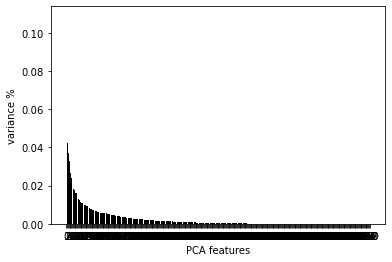

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
X = scaler.fit_transform(X_without)

pca = PCA()
principalComponents = pca.fit_transform(X)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

plt.show()

PCA_components = pd.DataFrame(principalComponents)

In [14]:
np.sum(pca.explained_variance_ratio_[:15])

0.4688037381608101

In [89]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import mixture

lowest_bic = np.infty
n_components_range = range(1, 45)
cv_types = ["spherical", "tied", "diag", "full"]

for features in range(5,20):
    bic = []
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(
                n_components=n_components, covariance_type=cv_type
            )
            gmm.fit(PCA_components.iloc[:,:features])
            bic.append(gmm.bic(PCA_components.iloc[:,:features]))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(20, 4))
    spl = plt.subplot(1, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + 0.2 * (i - 2)
        bars.append(
            plt.bar(
                xpos,
                bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
                width=0.2,
                color=color,
            )
        )
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
    plt.title("BIC score per model, "+ str(features) +" features")
    xpos = (
        np.mod(bic.argmin(), len(n_components_range))
        + 0.65
        + 0.2 * np.floor(bic.argmin() / len(n_components_range))
    )
    plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
    spl.set_xlabel("Number of components")
    spl.legend([b[0] for b in bars], cv_types)
    plt.show()

KeyboardInterrupt: 

In [ ]:
# from sklearn.manifold import TSNE
# tSNE = TSNE(n_components=3)
# tSNE_COMPS = tSNE.fit_transform(PCA_components)

# tSNE_PCA_components = pd.DataFrame(tSNE_COMPS)

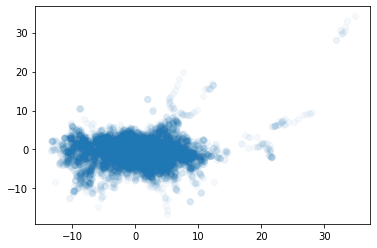

In [90]:
plt.scatter(PCA_components[0], PCA_components[2], alpha=.04)
plt.show()

In [57]:
from sklearn import mixture
from mpl_toolkits.mplot3d import Axes3D

components = 8
features = 15

gmm = mixture.GaussianMixture(n_components=components, covariance_type='full')
labels = gmm.fit_predict(PCA_components.iloc[:,:features])

dataset["gmmLabels-"+str(components)+str(features)] = labels

ValueError: Length of values (16747) does not match length of index (9945)

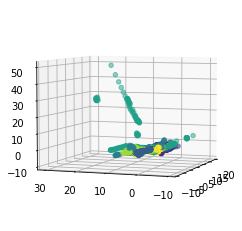

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(PCA_components[0], PCA_components[1], PCA_components[4], c=labels, alpha=.5)
ax.view_init(elev=5., azim=200)

In [27]:
import gower

kmeans = KMeans(n_clusters=4)
kmeans.fit_predict(PCA_components.iloc[:,:4])
score0 = kmeans.inertia_
score1 = silhouette_score(PCA_components.iloc[:,:4],kmeans.labels_,metric='euclidean')
score2 = silhouette_score(PCA_components.iloc[:,:4],kmeans.labels_,metric='correlation')
score4 = silhouette_score(PCA_components.iloc[:,:4],kmeans.labels_,metric=gower)
print(score0, score1, score4)

ValueError: Unknown metric <module 'gower' from 'c:\\Users\\Thoma\\.conda\\envs\\thesisProject\\lib\\site-packages\\gower\\__init__.py'>. Valid metrics are ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski', 'nan_euclidean', 'haversine'], or 'precomputed', or a callable

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score
import gower
# k_cand = list(np.arange(5,100,5))
# k_cand.extend(list(np.arange(100,500,50)))

k_cand = list(np.arange(2,20))
# k_cand.extend(list(np.arange(100,500,50)))

# for features in range(1,20):
for features in range(1,5):
    results = dict()
    
    for k in k_cand:

        kmeans = KMeans(n_clusters=k)
        kmeans.fit_predict(PCA_components.iloc[:,:features])
        score0 = kmeans.inertia_
        score1 = silhouette_score(PCA_components.iloc[:,:features],kmeans.labels_,metric='euclidean')
        score2 = silhouette_score(PCA_components.iloc[:,:features],kmeans.labels_,metric='correlation')
        score3 = silhouette_score(PCA_components.iloc[:,:features],kmeans.labels_,metric='manhattan')
        # score4 = silhouette_score(PCA_components.iloc[:,:features],kmeans.labels_,metric=gower)
        results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2,'s3':score3}

    fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
    plt.title('features '+ str(features))
    axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
    axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='euclidean')
    axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
    axs[1].plot([i for i in results.keys()],[i['s3'] for i in results.values()],'o-',label='Manhattan')
    # axs[1].plot([i for i in results.keys()],[i['s4'] for i in results.values()],'o-',label='Gower')
    for ax in axs:
        ax.set_xticks(k_cand)
        ax.set_xlabel('K')
        ax.legend()

    plt.savefig("features-minmax-scale"+str(features)+".png") 
    plt.show()

NameError: name 'PCA_components' is not defined

In [28]:
dataset = dataset.merge(Y, how='inner', on=["year","country"])

In [ ]:
dataset

In [39]:
checkingMatrix = dataset.iloc[:,-10:]

In [29]:
import datetime
x = datetime.datetime.now()
dataset.to_csv(str(x.strftime("%Y%m%d"))+"cluster.csv")

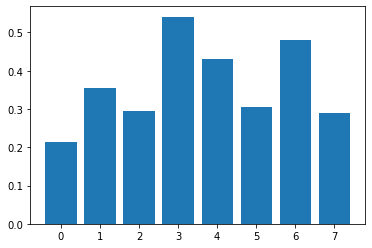

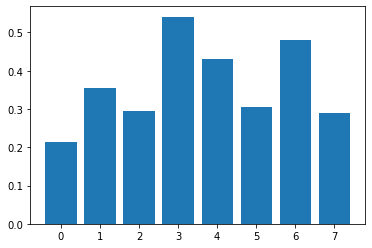

LeveneResult(statistic=101.2174309813332, pvalue=1.6535047387767613e-143)
NormaltestResult(statistic=376.99038381266774, pvalue=1.3727083953248806e-82) LeveneResult(statistic=101.2174309813332, pvalue=1.6535047387767613e-143)
LeveneResult(statistic=172.75634326033457, pvalue=9.730323902160833e-39)
Compare v2x_libdem, of cluster 0  against: 1 : Ttest_indResult(statistic=-18.91815186127821, pvalue=7.999242172564416e-77)

LeveneResult(statistic=23.545947509312242, pvalue=1.3168253819091915e-06)
Compare v2x_libdem, of cluster 0  against: 2 : Ttest_indResult(statistic=-4.474360229149568, pvalue=8.107284058014214e-06)

LeveneResult(statistic=169.98604053757919, pvalue=1.5652042830402001e-37)
Compare v2x_libdem, of cluster 0  against: 3 : Ttest_indResult(statistic=-26.203481958410443, pvalue=1.4175492747873408e-132)

LeveneResult(statistic=3.615044096153459, pvalue=0.05741554331474952)
Compare v2x_libdem, of cluster 0  against: 4 : Ttest_indResult(statistic=-7.542241202838989, pvalue=7.220626

[[(2.8081811911260134e-26, 0.07627086299110498),
  (4.6735977121285916e-20, 2.4691347419222125e-42),
  (0.6834285697817613, 1.9200426629943882e-10),
  (1.0562506760296116e-96, 1.0860686516806311e-59),
  (2.5797051010977682e-08, 0.0002820360152392967),
  (0.06873071670508406, 2.3334382233466233e-25),
  (2.818836940082347e-78, 1.410840194970686e-161),
  1,
  0],
 [(2.8081811911260134e-26, 0.07627086299110498),
  (4.6735977121285916e-20, 2.4691347419222125e-42),
  (0.6834285697817613, 1.9200426629943882e-10),
  (1.0562506760296116e-96, 1.0860686516806311e-59),
  (2.5797051010977682e-08, 0.0002820360152392967),
  (0.06873071670508406, 2.3334382233466233e-25),
  (2.818836940082347e-78, 1.410840194970686e-161),
  1,
  0],
 [(2.8081811911260134e-26, 0.07627086299110498),
  (4.6735977121285916e-20, 2.4691347419222125e-42),
  (0.6834285697817613, 1.9200426629943882e-10),
  (1.0562506760296116e-96, 1.0860686516806311e-59),
  (2.5797051010977682e-08, 0.0002820360152392967),
  (0.06873071670508406

In [55]:
import scipy.stats as scStat

setToCompare = "gmmLabels-84"
clusters = len(checkingMatrix[setToCompare].unique())
democracyScore = "v2x_libdem"

clusters = len(checkingMatrix[setToCompare].unique())

bars = [np.mean(checkingMatrix[checkingMatrix[setToCompare]==i][democracyScore].dropna().values) for i in range(clusters)]
plt.bar(range(clusters),bars)
plt.xticks(range(clusters))
plt.show()


# zeroArray = np.zeros((clusters+1,clusters+1))
zeroArray = [[0]*(clusters+1)]*(clusters+1)

barlett = [checkingMatrix[checkingMatrix[setToCompare]==i][democracyScore].dropna().values for i in range(clusters)]
barlettTest = scStat.levene(*barlett)

print(barlettTest)

for i in range(clusters):
    # print(len(checkingMatrix[checkingMatrix[setToCompare]==i]["v2x_partipdem"]))
    compareSet = checkingMatrix[checkingMatrix[setToCompare]==i][democracyScore].dropna().values
    if len(compareSet) > 8:
        normality_v2X_PartiDem = scStat.normaltest(compareSet)
        print(normality_v2X_PartiDem, barlettTest)
        for z in range(clusters):
            tTest = 0
            if i != z:
                compareSet2 = checkingMatrix[checkingMatrix[setToCompare]==z][democracyScore].dropna().values
                levene = scStat.levene(compareSet,compareSet2)
                print(levene)

                if len(compareSet2) > 8:
                    tTest = scStat.ttest_ind(compareSet,compareSet2)
                    zeroArray[i][z] = (tTest[1], levene[1])
                    print("Compare "+ democracyScore +", of cluster", i, " against:", z, ":", tTest)
                    print("")
            else:
                zeroArray[i][z] = 1
    print("")

zeroArray